## 1. Project Overview
#### Problem Statement

 Diabetes is a chronic metabolic disease with increasing global prevalence and significant long-term health consequences if not detected and managed early. In many healthcare settings, diagnosis often occurs only after symptoms become severe, limiting the effectiveness of preventive interventions. Given the availability of routinely collected clinical and demographic data, there is a growing need for data-driven methods that can support early identification of individuals at high risk of developing diabetes.

 This project aims to develop a machine learning model capable of predicting diabetes risk using patient-level clinical and lifestyle information. The goal is not to replace medical diagnosis, but to explore how statistical learning methods can assist healthcare providers in identifying high-risk individuals for timely monitoring and intervention.

#### Motivation

My motivation for this project stems from an interest in applying data science techniques to real-world healthcare problems, particularly those with strong public health implications. Diabetes presents an ideal case study due to its measurable risk factors, well-understood clinical indicators, and the practical value of early prediction.

Through this project, I sought to gain hands-on experience with the complete data science workflow. From data cleaning and exploratory analysis to feature engineering, model selection, and evaluation while also understanding how modeling decisions impact performance in imbalanced medical datasets. By comparing baseline models with advanced ensemble methods such as XGBoost, this project provided practical insight into how different machine learning approaches handle non-linear relationships and class imbalance in clinical data.

Ultimately, this work reinforced my interest in data-driven healthcare research and the use of machine learning to support evidence-based decision-making in medical and public health contexts.

## 2. Libraries and Environment Setup


In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and feature engineering
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## 3. Data Loading

In [3]:
data = pd.read_csv(r"C:\Users\PRISCILLA EBIMOBOERE\Downloads\diabetes_prediction_dataset.csv")

In [4]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## 4. Data Cleaning and Preprocessing

Research:

BMI

Plausible Minimum BMI: 12. This is the lower bound for BMI, where survival is possible but associated with extreme underweight and significant health risks. Plausible Maximum BMI: 70. This represents the upper bound, typically seen in extreme cases of severe obesity, with significant health risks and medical complications. HbA1c_level

Normal Range: Below 5.7% Pre-diabetes: 5.7% to 6.4% Diabetes: 6.5% or higher. Plausible Ranges for blood_glucose_level:

Minimum value: Around 40 mg/dL (2.2 mmol/L), though such low levels would indicate hypoglycemia, which is a medical emergency. Maximum value: Up to 600 mg/dL (33.3 mmol/L) or more, though values this high are typically seen in severe cases of uncontrolled diabetes.

In [5]:
# Check for missing values
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
# Dataset info and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [8]:
# Check data types

data.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [10]:
# Convert age to int

data["age"] = data["age"].astype(int)

In [11]:
data.dtypes

gender                  object
age                      int64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [12]:
# Remove duplicates

data = data.drop_duplicates(keep = "first")

In [13]:
# Desccriptive statistics for numerical features

data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,96112.0,41.798287,22.472901,0.00,24.0,43.00,59.00,80.00
hypertension,96112.0,0.077628,0.267587,0.00,0.0,0.00,0.00,1.00
heart_disease,96112.0,0.040817,0.197867,0.00,0.0,0.00,0.00,1.00
bmi,96112.0,27.321923,6.768534,10.01,23.4,27.32,29.86,95.69
HbA1c_level,96112.0,5.532618,1.073288,3.50,4.8,5.80,6.20,9.00
blood_glucose_level,96112.0,138.221013,40.911287,80.00,100.0,140.00,159.00,300.00
diabetes,96112.0,0.088251,0.283661,0.00,0.0,0.00,0.00,1.00


#### Observation

The minimum age recorded is 0.0 years, while the maximum is 80 years. The extremely low minimum age warrants further investigation for data entry errors.

The minimum BMI is 10, which is significantly below the plausible range for a healthy human. This suggests a potential data entry error or outlier.

The maximum BMI is 90, which exceeds the plausible upper limit, indicating the presence of an outlier.

The minimum HbA1c level is 3.5%, which is lower than expected, suggesting it could be an inaccurate measurement or error.

The maximum HbA1c level of 9% may be considered an outlier depending on the population under study.

Outlier removal is a possible solution

In [14]:
(data["age"]==0).sum()

np.int64(900)

In [15]:
data["age"].value_counts().loc[[0,80]]

age
0      900
80    4932
Name: count, dtype: int64

#### Create Box and histogram plot for each numerical feature

In [17]:
# investigate age against BMI to identify outliers
def create_box_histplot(data_frame,columns= [] ,hist = False, box = False):
    # make a copy of dataframe
    df = data_frame.copy()

    # number of columns for subplot is same as number of features
    ncolumns = len(columns)
    # Set number of columns and dynamic figure size
    subplot_width = 5  # Set desired width per subplot
    subplot_height = 5  # Set desired height per subplot
    figsize = (ncolumns * subplot_width, subplot_height)     
    fig, axes = plt.subplots(nrows=1, ncols=ncolumns,figsize = figsize)
    
    for index, feature in enumerate(columns):
        if hist == True:
            sns.histplot(data = df[feature], ax = axes[index])
        if box == True:
            sns.boxplot(data = df[feature], ax=axes[index])
    plt.tight_layout()
    plt.show();

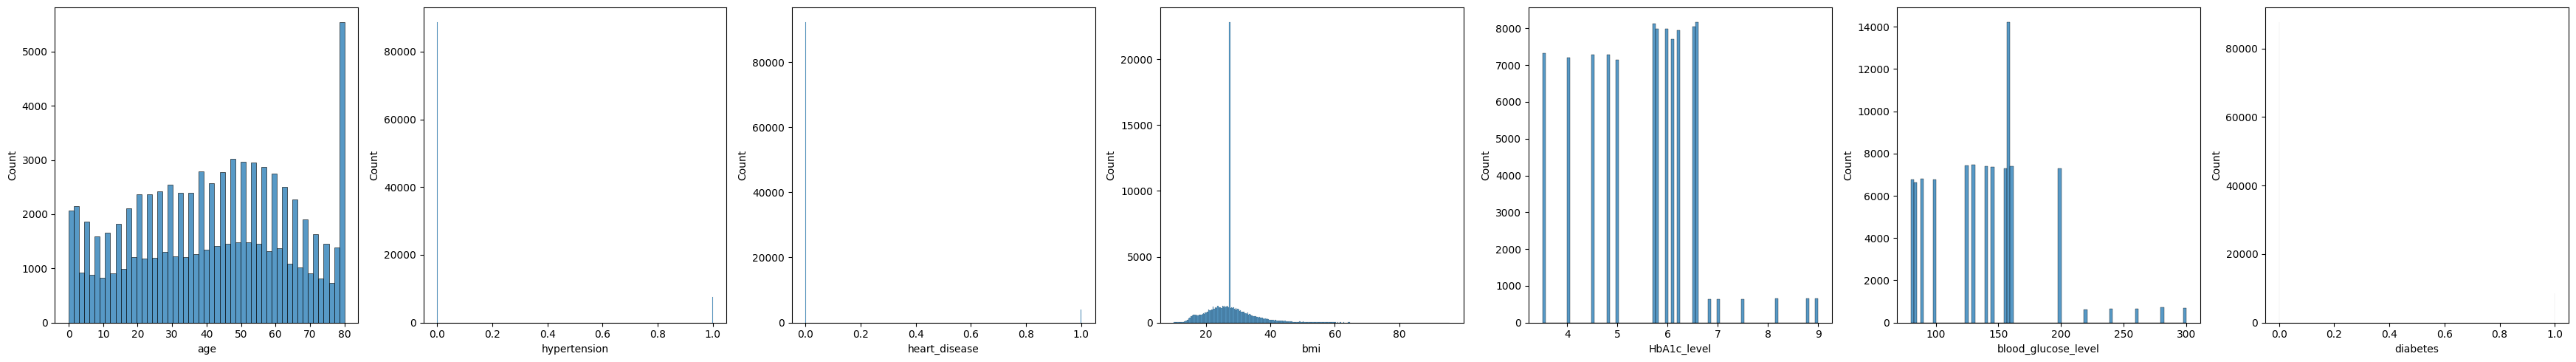

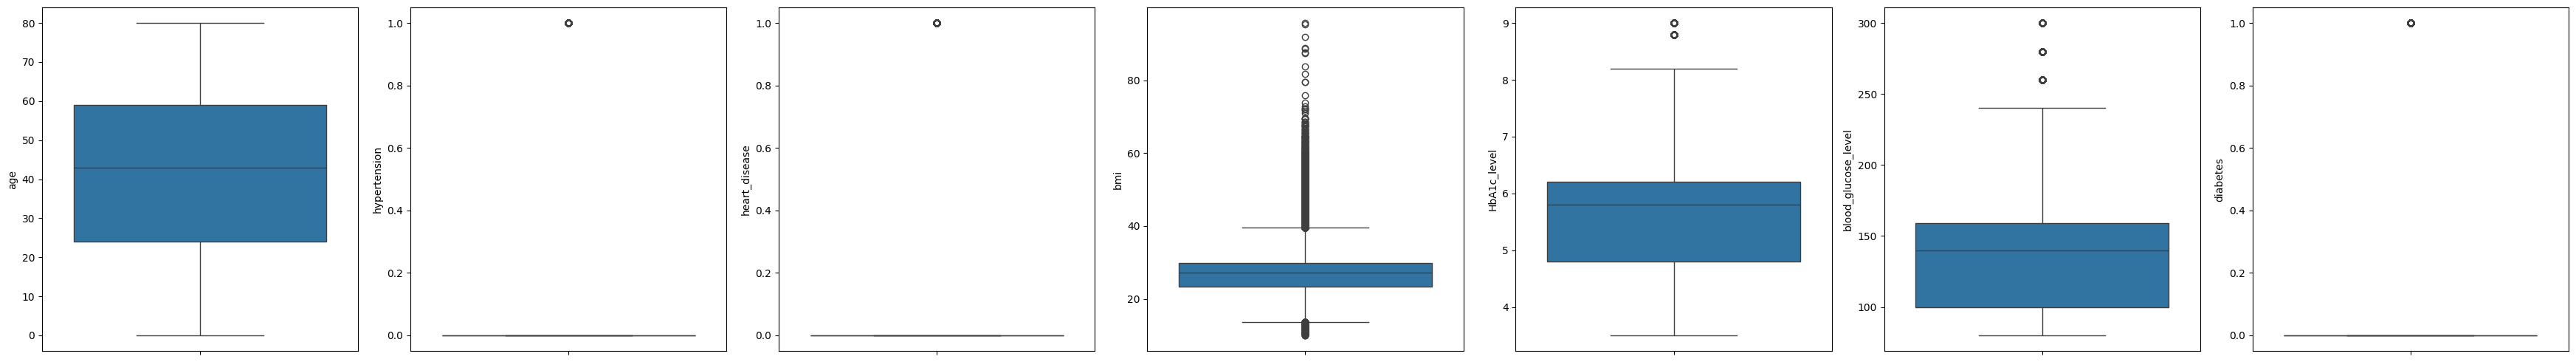

In [18]:
create_box_histplot(data_frame=data, columns = data.select_dtypes(exclude = 'object').columns.to_list(),hist = True)
create_box_histplot(data_frame=data, columns = data.select_dtypes(exclude = 'object').columns.to_list(), box= True)

#### Observations¶

Outliers are present on BMI, Blood glucose level and diabetes.

In [19]:
# write a fuction to calculate outliers
def find_outliers(data_frame,feature, upper = False, lower = False):
    target_feature = "diabetes"
    # make a copy of dataframe
    df = data_frame.copy()
     
    # calculate Q1 and Q3 and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # find lower and upper bound
    if lower == True:
        lower_bound = Q1 - (IQR *1.5)
        outlier_df = df[df[feature] < lower_bound]
        print(f"lower bound of {feature} is: {lower_bound}")
    if upper == True:
        upper_bound = Q3 + (IQR * 1.5)
        outlier_df = df[df[feature] > upper_bound]
        print(f"Upper bound of {feature} is: {upper_bound}")
        
    print(f"the size of the data that are outliers is {outlier_df.shape}\n")
    print(f"distribution of target features in outlier is {outlier_df[target_feature].value_counts()}")

In [20]:
# find upper outliers for BMI

find_outliers(data_frame=data, feature="bmi", upper=True)

Upper bound of bmi is: 39.55
the size of the data that are outliers is (4940, 9)

distribution of target features in outlier is diabetes
0    3681
1    1259
Name: count, dtype: int64


In [21]:
# find lower outliers for BMI

find_outliers(data_frame=data, feature="bmi", lower=True)

lower bound of bmi is: 13.709999999999997
the size of the data that are outliers is (414, 9)

distribution of target features in outlier is diabetes
0    406
1      8
Name: count, dtype: int64


Removing all outliers in this case might result in significant loss of information, looking at the number of records classified as outliers and the distribution of target feature

In [22]:
# find outliers in HbA1c_level

find_outliers(data_frame=data, feature="HbA1c_level", upper=True)

Upper bound of HbA1c_level is: 8.3
the size of the data that are outliers is (1312, 9)

distribution of target features in outlier is diabetes
1    1312
Name: count, dtype: int64


Over 1000 records fall above the upper bound

All patients within this category are diabetic. Therefore removing outliers above the upper bound will result in significant information loss

In [23]:
# Find outliers in blood glucose level

find_outliers(data_frame=data, feature="blood_glucose_level", upper=True)

Upper bound of blood_glucose_level is: 247.5
the size of the data that are outliers is (2031, 9)

distribution of target features in outlier is diabetes
1    2031
Name: count, dtype: int64


Over 2000 records fall above the upper bound

All patients above the upper bound of blood_glucose_level are diabetic, suggesting that altering that value will result in significant information loss

#### Inspect categorical features¶

In [24]:
# select categorical features from data
categorical_df = data.select_dtypes(include = "object")
categorical_df.head()

,gender,smoking_history
0,Female,never
1,Female,No Info
2,Male,never
3,Female,current
4,Male,current


In [25]:
cat_list = categorical_df.columns.to_list()

for feature in cat_list:
    print(categorical_df[feature].value_counts(),"\n")

gender
Female    56142
Male      39952
Other        18
Name: count, dtype: int64 

smoking_history
never          34398
No Info        32853
former          9299
current         9197
not current     6367
ever            3998
Name: count, dtype: int64 



obsevations

Wrong gender category "Others"

Similar smoking history: former, not current, ever

In [29]:
# reassign "other" in gender cateogry to the mode of that feature (female)

data["gender"] = data["gender"].replace("Other", "Female")
data["gender"].value_counts()

gender
Female    56160
Male      39952
Name: count, dtype: int64

In [30]:
# Convert Gender to all lower case

data["gender"] = data["gender"].str.lower()

In [31]:
# Group "former", "not current" and "ever" into a single category called "past_smoker"

data["smoking_history"] = data["smoking_history"].replace({"former":"past_smoker",
                                                           "not current": "past_smoker",
                                                          "ever": "past_smoker"})



In [32]:
data["smoking_history"].value_counts()

smoking_history
never          34398
No Info        32853
past_smoker    19664
current         9197
Name: count, dtype: int64

In [33]:
# Convert smoking history to all lower case

data["smoking_history"] = data["smoking_history"].str.lower()

In [34]:
# Check for relationship between age, BMI and smoking history¶

## Patients below the age 10 with smoking history

below_adolescence = data[data["age"] <= 10]

below_adolescence["smoking_history"].value_counts()

smoking_history
no info        8757
never          1288
past_smoker     226
current          21
Name: count, dtype: int64

In [35]:
below_adolescence[below_adolescence["smoking_history"] == "past_smoker"]["diabetes"].value_counts()

diabetes
0    224
1      2
Name: count, dtype: int64

In [36]:
below_adolescence[below_adolescence["smoking_history"] == "current"]["diabetes"].value_counts()

diabetes
0    21
Name: count, dtype: int64

Reasons to Remove These Records: Biological Implausibility: It is highly unlikely for children under 10 to have a legitimate smoking history, making these records suspect.

Inconsistent with Target Feature: The fact that just 2 of these children are diabetic could indicate a lack of correlation between smoking history and the target outcome (diabetes) in this age group. This inconsistency suggests these records do not contribute meaningful information to the model.

Data Integrity: Retaining implausible records could introduce noise and reduce model performance. Removing them is likely to lead to a more accurate and reliable model.

In [37]:
# Filter and drop records where age is 10 or below and smoking history is either "current" or "past_smoker"
filtered_data = data[~((data["age"] <= 10) & 
                      (data["smoking_history"].isin(["current", "past_smoker"])))]

In [38]:
# check if the filer took effect
filtered_data[filtered_data["age"] <=10]["smoking_history"].unique()

array(['no info', 'never'], dtype=object)

In [76]:
filtered_data.to_csv("Clean_data.csv", index = False)

## 5. Exploratory Data Analysis (EDA)

In [77]:
#### Split data to numerical and categorical analysis

numerical_df = data.select_dtypes(exclude = "object")
categorical_df = data.select_dtypes(include = "object")

In [78]:
numerical_df.head(2)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80,0,1,25.19,6.6,140,0
1,54,0,0,27.32,6.6,80,0


In [79]:
categorical_df.head(2)

,gender,smoking_history
0,female,never
1,female,no info


#### Univariate data analysis

In [80]:
numerical_df.head(2)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80,0,1,25.19,6.6,140,0
1,54,0,0,27.32,6.6,80,0


In [81]:
def create_box_histplot(data_frame,columns= [] ,hist = False, box = False):
    # make a copy of dataframe
    df = data_frame.copy()

    # number of columns for subplot is same as number of features
    ncolumns = len(columns)
    # Set number of columns and dynamic figure size
    subplot_width = 5  # Set desired width per subplot
    subplot_height = 5  # Set desired height per subplot
    figsize = (ncolumns * subplot_width, subplot_height)     
    fig, axes = plt.subplots(nrows=1, ncols=ncolumns,figsize = figsize)
    
    for index, feature in enumerate(columns):
        if hist == True:
            sns.histplot(data = df[feature], ax = axes[index])
        if box == True:
            sns.boxplot(data = df[feature], ax=axes[index])
    plt.tight_layout()
    plt.show();

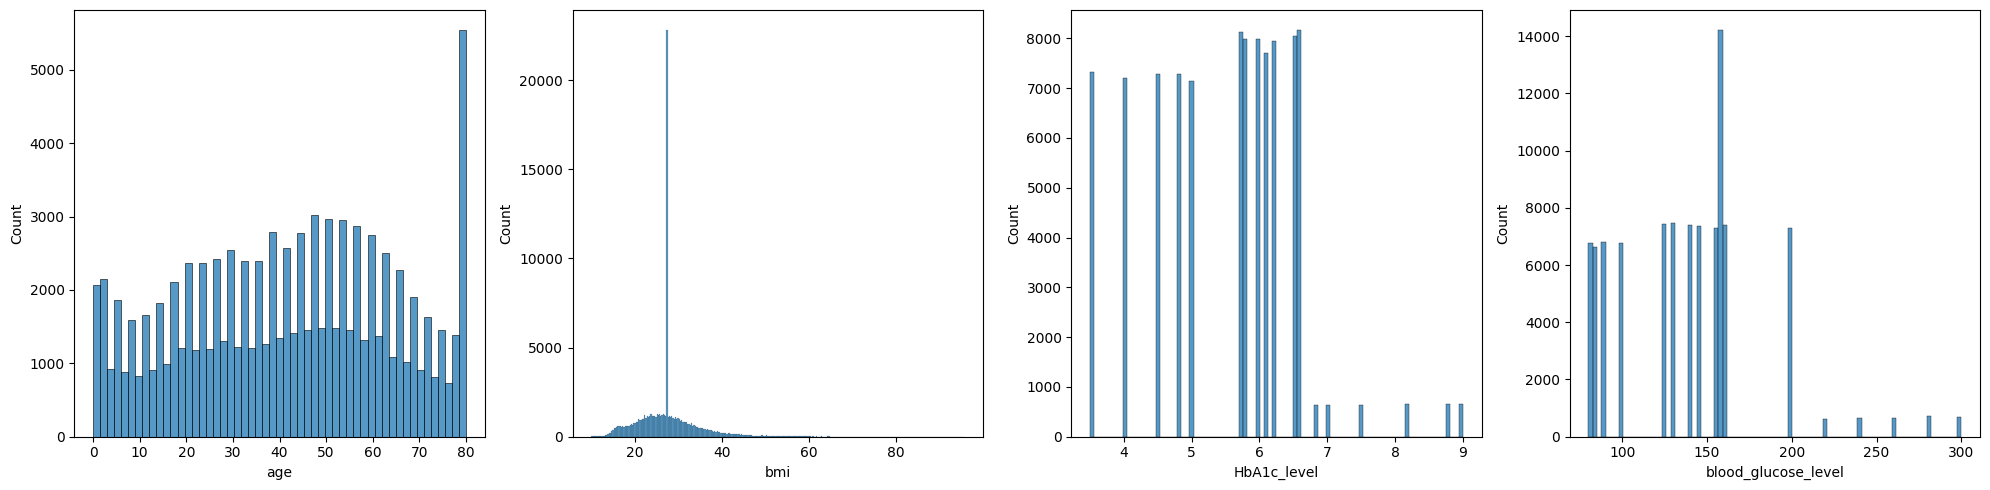

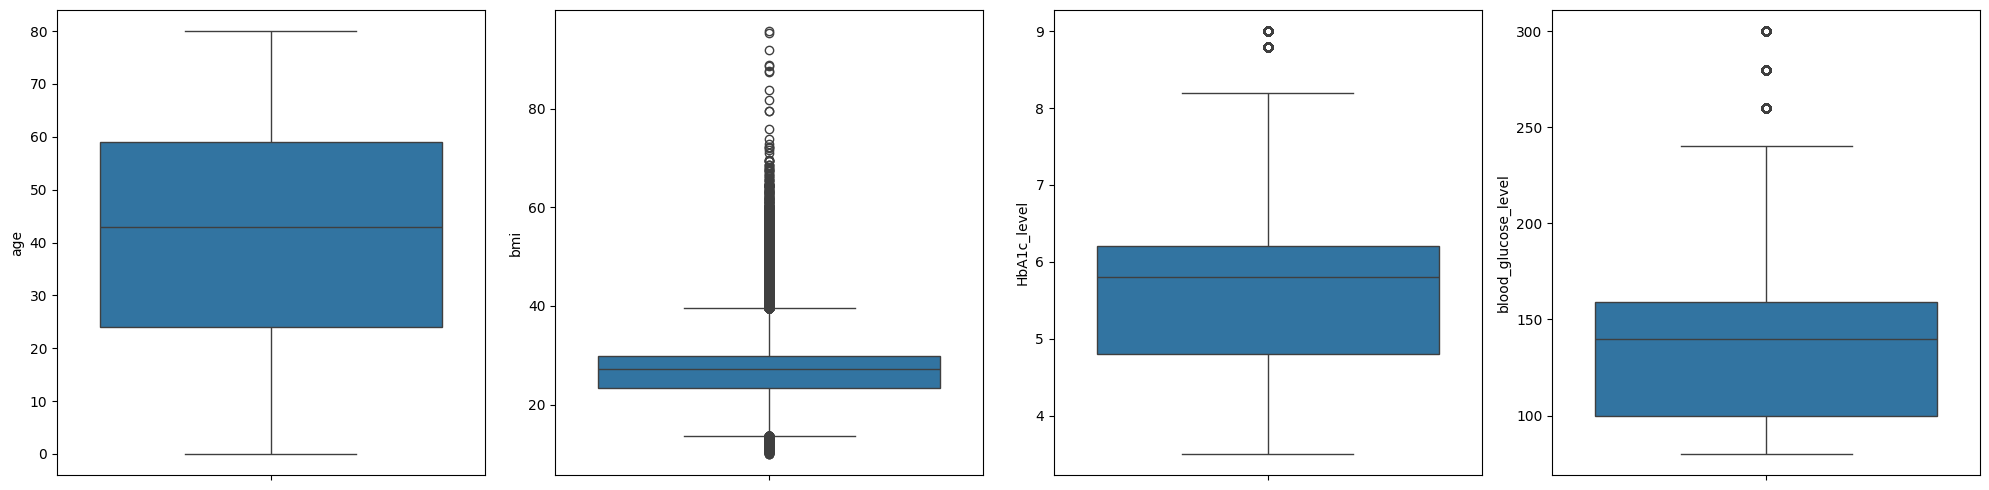

In [82]:
create_box_histplot(data_frame=numerical_df, columns=["age", "bmi", "HbA1c_level", "blood_glucose_level"], hist = True)
create_box_histplot(data_frame=numerical_df,columns=["age", "bmi", "HbA1c_level", "blood_glucose_level"], box = True)

1. Age Distribution The age distribution across the dataset appears relatively uniform with individuals spanning a wide age range. However, there is a notable spike at age 80. This anomaly could indicate a potential data entry issue, such as many individuals being recorded with a default age of 80, or it could reflect a genuine trend where a significant number of our population falls into the elderly category.
- Action: I recommend further investigation to determine whether this spike is a data anomally or a reflection of our target demographic. If it is a data anomally, appropriate data cleaning steps will be taken.
2. BMI Distribution The distribution of BMI shows an unusual and sharp spike around a value of 25. This concentration might suggest that many individuals have their BMI recorded at this specific value, potentially due to rounding or the use of a default value. Additionally, the overall distribution is right-skewed, indicating that while most individuals have a BMI within a healthy range, there are significant outliers with much higher values.
- Action: I recommend reviewing the data collection and recording processes to ensure accuracy. Additionally, outlier management strategies should be considered to prevent these extreme values from distorting the analyses.
3. HbA1c Level Distribution The distribution of HbA1c levels reveals distinct and sharp peaks around values such as 5.5, 6, and 7. This pattern suggests that these values could be commonly used thresholds in clinical practice. While this might be expected, the sharpness of these peaks raises questions about the granularity of the data—potentially indicating that the data is being binned or rounded rather than recorded precisely.
- Action: I recommend assessing the data recording practices to understand whether this rounding is intentional or a result of data processing. More granular data might provide deeper insights into health outcomes.
4. Blood Glucose Level Distribution The blood glucose level distribution shows similar characteristics to the HbA1c levels, with noticeable peaks at common clinical thresholds such as 100, 150, and 200. The distribution is right-skewed, with a long tail indicating that while most individuals have normal glucose levels, a significant minority exhibit much higher levels.
- Action: I propose a closer examination of these peaks to determine if they correspond to clinical decision thresholds or if there are underlying data quality issues. Addressing skewness may also involve transforming the data for more accurate predictive modeling.

In [83]:
# write a function to plot pie chart for binary numerical features

def plot_pie(data, columns = []):
    df = data.copy()
    
    # number of columns for subplot is same as number of features
    ncolumns = len(columns)
    
    # Set number of columns and dynamic figure size
    subplot_width = 5  # Set desired width per subplot
    subplot_height = 5  # Set desired height per subplot
    
    # calculate appropriate size for subplot
    figsize = (ncolumns * subplot_width, subplot_height)     
    fig, axes = plt.subplots(nrows=1, ncols=ncolumns,figsize = figsize)
    
    # flatten axes for iteration
    axes = axes.flatten()
    
    # If there's only one feature, 'axes' will not be an array, so handle this case
    if ncolumns == 1:
        axes = [axes]
        
    for index, feature in enumerate(columns):
        # check if feature exist on the specified dataframe
        if feature in df.columns:
            
            # convert data into string if numerical
            df[feature] = df[feature].astype("object")
            values = df[feature].value_counts()
            axes[index].pie(values, labels=values.index, autopct='%1.1f%%', startangle=140)
            axes[index].set_title(f'Distribution of {feature}')
            
        # raise warning if feature does not exist on specified data
        else:
            print(f"Feature '{feature}' not found in the dataset.")

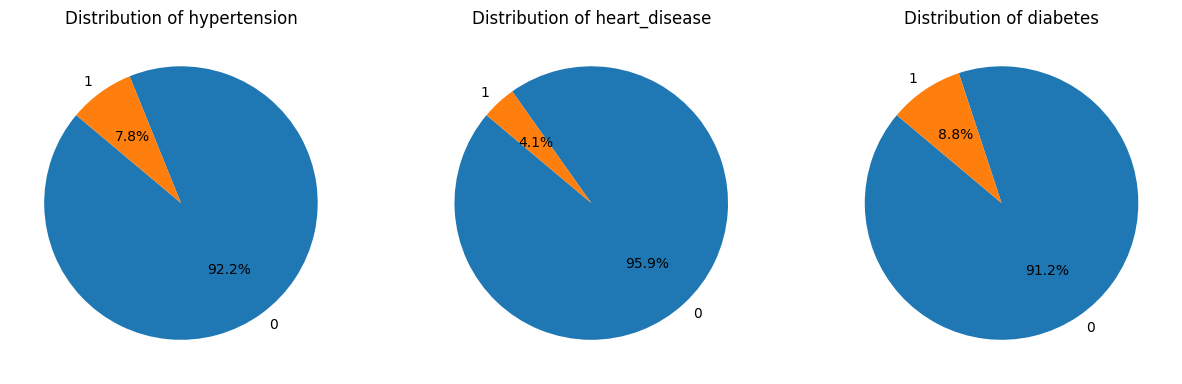

In [84]:
plot_pie(data, ["hypertension", "heart_disease", "diabetes"])

The pie charts provided illustrate the distribution of three binary health conditions within the dataset: hypertension, heart disease, and diabetes. Each chart shows the proportion of individuals with (label "1") and without (label "0") these conditions.

Hypertension Distribution

Distribution: 92.2% of the population does not have hypertension (label "0"), while 7.8% have hypertension (label "1").
Implication: There is a significant class imbalance, with a large majority of the population being free from hypertension.

Heart Disease Distribution

Distribution: 95.9% of the population does not have heart disease (label "0"), while only 4.1% have heart disease (label "1").
Implication: The class imbalance is even more pronounced here, with a very small proportion of the population having heart disease.

Diabetes Distribution

Distribution: 91.2% of the population does not have diabetes (label "0"), while 8.8% have diabetes (label "1").
Implication: Similar to hypertension, there is a notable class imbalance, with a majority of the population being non-diabetic.

Possible impact of imbalance on ML model:

1. Reduced Feature Importance:
    
- The model might downplay the importance of hypertension and heart disease as predictors, simply because these features are imbalanced. This could lead to underutilization of these features, which may be critical in predicting diabetes.
    
2. Model Overfitting or Underfitting:

- The imbalance in the independent features could lead to the model overfitting to the majority class of these features (predicting no hypertension or no heart disease) without learning the true relationship between these features and the target variable (diabetes). This might result in a model that is not generalizable to new data.

3. Limited Generalization:

- If the model relies heavily on these imbalanced features, it might struggle to generalize when encountering cases where these conditions (hypertension, heart disease) are more balanced or when the minority classes are more prevalent.
Strategies to Mitigate the Impact:

4. Resampling the Target Feature:

- Apply oversampling of the minority class (those with diabetes) or undersampling of the majority class to create a more balanced dataset, improving the model’s ability to detect diabetes cases.

5. Use of Class Weights:
    
- Introduce class weights in the model’s loss function to penalize misclassification of the minority class more heavily, ensuring that the model pays more attention to identifying diabetes cases.

6. Feature Engineering:
    
- Enhance the features by combining them or creating new derived features that capture more balanced and informative patterns related to diabetes.

7. Evaluation Metrics:

- Use evaluation metrics like F1-score, precision, recall, and the area under the precision-recall curve (AUC-PR) that are better suited for imbalanced data instead of relying on accuracy alone.

#### Bi-variate analysis for continuous numerical data

<Axes: xlabel='age', ylabel='bmi'>

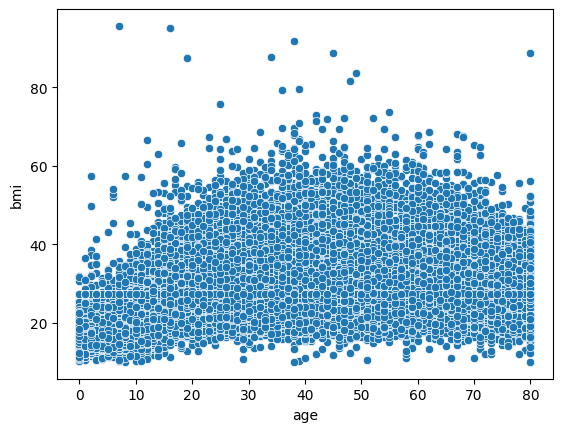

In [85]:
# Create scatter plot of Age against BMI
sns.scatterplot(x= data["age"], y = data["bmi"])

Observations

- BMI values are widely distributed across the age range, with most points clustered between BMI 20 and 60.

- BMI values slightly increase with age up to around 50 years, after which they appear to stabilize or slightly decrease.

- Outliers exist, particularly with BMI values exceeding 60, spread across various age groups.

- BMI variation is high across all ages, showing that individuals of the same age can have widely different BMI values.

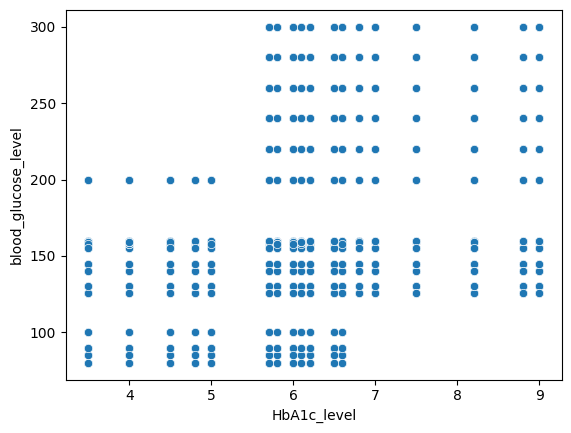

In [86]:
# Create scatter plot of heamoglobin level against blood glucose level
sns.scatterplot(x= data["HbA1c_level"], y = data["blood_glucose_level"]);

Observation

- The spread of data points also indicates that for the same HbA1c level, there can be a wide range of blood glucose levels, showing variability in the data

#### Bivariate analysis for Binary numerical columns

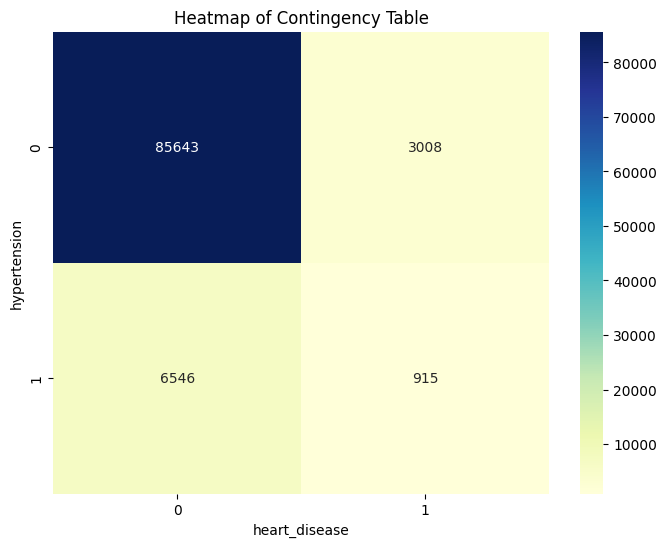

In [87]:
# Generate Contingency Table
contingency_table = pd.crosstab(data['hypertension'], data['heart_disease'])

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Contingency Table')
plt.ylabel('hypertension')
plt.xlabel('heart_disease')
plt.show()

Observations

- Most individuals in the dataset do not have hypertension and do not have heart disease.
- The number of individuals with heart disease is higher among those without hypertension (3,006) than those with hypertension (915).

#### Multivariate EDA for Numerical features

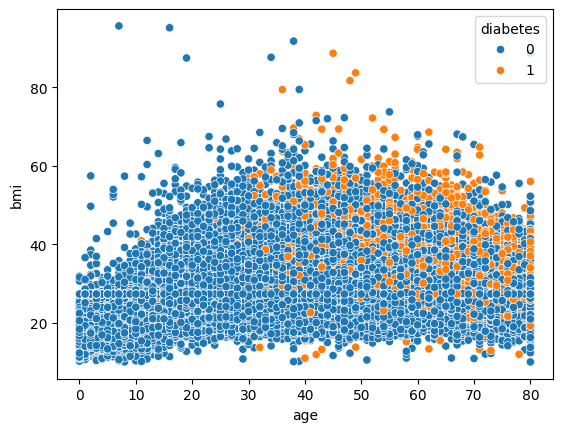

In [88]:
# Create scatter plot of Age, BMI and diabetes
sns.scatterplot(x= data["age"], y = data["bmi"], hue = data["diabetes"]);

Observations

- Age and BMI Interaction: The plot suggests that the interaction between age and BMI might be important. For instance, a high BMI might be a stronger predictor of diabetes in older individuals compared to younger ones.
- Consider creating interaction terms (e.g., Age*BMI) to capture combined effects.
- Use models that handle non-linear relationships well (e.g., Decision Trees, Random Forests, Gradient Boosting Machines).
- Consider creating age groups (e.g., <40, 40-70, >70) to capture non-linear relationship betwen age and diabetes.

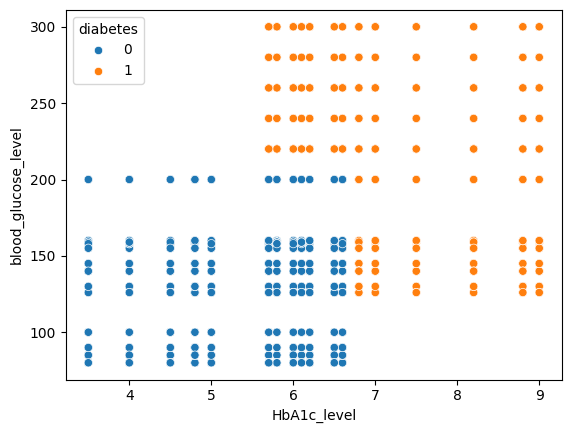

In [89]:
# Create scatter plot of heamoglobin level, blood glucose level against diabetes
sns.scatterplot(x= data["HbA1c_level"], y = data["blood_glucose_level"], hue = data["diabetes"]);

Observation

- Both HbA1c level and blood glucose level are critical features for predicting diabetes. Their strong association with diabetes suggests they should be prominently included in the model.
- Consider adding a new feature to your dataset that flags whether the HbA1c level is above or below 6. This binary feature can provide a strong signal to the model, allowing it to implicitly learn the threshold without explicitly setting one.
- Consider Converting the continuous HbA1c levels into bins or categories (e.g., <6, 6-7, >7).

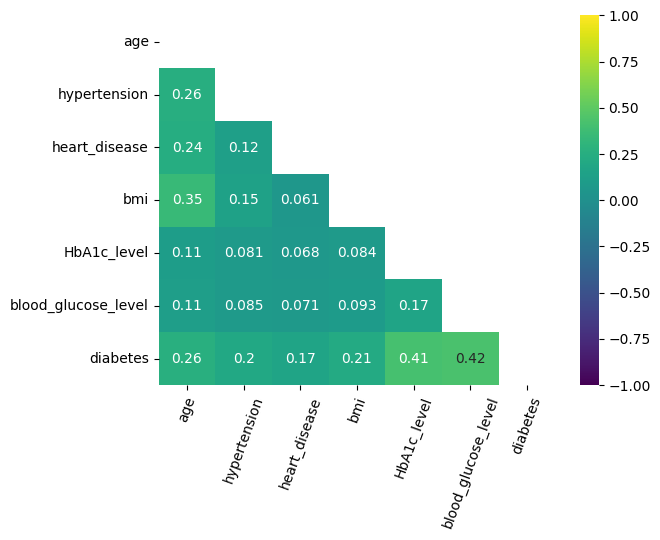

In [90]:
mask = np.triu(np.ones_like(numerical_df.corr(), dtype = bool))
sns.heatmap(data = numerical_df.corr(), cmap = "viridis", vmax=1, vmin=-1, annot = True, mask = mask)
plt.xticks(rotation = 70);

Observations

- HbA1c Level (0.41): Strong positive correlation with diabetes.
- Blood Glucose Level (0.42): Strong positive correlation with diabetes.
- BMI (0.21): Moderate positive correlation with diabetes.
- Age (0.26): Moderate positive correlation with diabetes.
- Hypertension (0.20): Weak to moderate positive correlation with diabetes.
- Heart Disease (0.17): Weak positive correlation with diabetes.

#### Categorical Features

In [91]:
categorical_df.head()

,gender,smoking_history
0,female,never
1,female,no info
2,male,never
3,female,current
4,male,current


#### Univariate analysis 

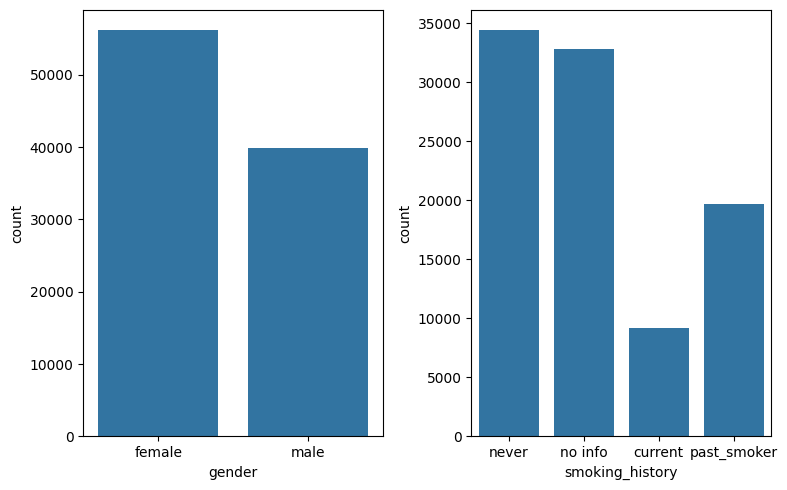

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,5))
sns.countplot(data = categorical_df, x = "gender", ax =axes[0])
sns.countplot(data = categorical_df, x = "smoking_history", ax =axes[1]);
plt.tight_layout()

Gender Distribution:

- More females (around 55,000) than males (around 40,000) in the dataset.
- There is a noticeable gender imbalance that could affect analysis.
    
Smoking History Distribution:

- The largest group is individuals who have never smoked, followed closely by those with missing information ("no info").
- The fewest individuals are current smokers, with past smokers being in the middle.
- Significant missing data ("no info") in smoking history needs to be addressed for accurate modeling.

#### Bi-variate analysis for categorical features

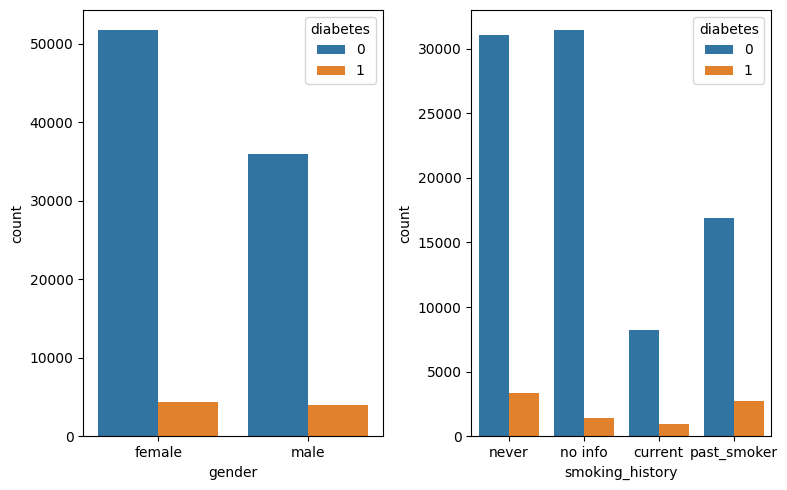

In [93]:
#check distribution of target feature across all category

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,5))
sns.countplot(data = categorical_df, x = "gender", ax =axes[0], hue=data["diabetes"])
sns.countplot(data = categorical_df, x = "smoking_history", ax =axes[1], hue=data["diabetes"]);
plt.tight_layout()

## 6. Feature Engineering and Data Transformation


#### Data Transformation

In [94]:
data = pd.read_csv("Clean_data.csv")

In [95]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,female,80,0,1,never,25.19,6.6,140,0
1,female,54,0,0,no info,27.32,6.6,80,0
2,male,28,0,0,never,27.32,5.7,158,0
3,female,36,0,0,current,23.45,5.0,155,0
4,male,76,1,1,current,20.14,4.8,155,0


In [96]:
def transform_data(dataframe, target):
    df = dataframe.drop([target], axis =1)
    
    numerical_features = df.select_dtypes(exclude = "object").columns.to_list()
    categorical_features = df.select_dtypes(include = "object").columns.to_list()
    
    # Transformers
    numerical_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(drop = 'if_binary')
    
    # define column transformer object
    pipeline = ColumnTransformer(
    [
       ( "numerical transformer", numerical_transformer, numerical_features),
        ("categorical transformer", categorical_transformer, categorical_features)
    ])
    
    # apply transformer
    transformed_array = pipeline.fit_transform(df)
    
    # Get the transformed column names
    transformed_numerical_columns = pipeline.transformers_[0][2]
    transformed_categorical_columns = pipeline.transformers_[1][1].get_feature_names_out(input_features=categorical_features)
    
    # Combine numerical and categorical transformed column names
    transformed_column_names = list(transformed_numerical_columns) + list(transformed_categorical_columns)
    
    # convert array to dataframe
    transformed_data = pd.DataFrame(transformed_array, columns=transformed_column_names)
    
    
    # attach target feature
    transformed_data[target] = dataframe[target]
    
    return transformed_data

In [97]:
# transform data
transformed_data = transform_data(dataframe=data, target="diabetes")
transformed_data.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_male,smoking_history_current,smoking_history_never,smoking_history_no info,smoking_history_past_smoker,diabetes
0,1.000,0.0,1.0,0.177171,0.563636,0.272727,0.0,0.0,1.0,0.0,0.0,0
1,0.675,0.0,0.0,0.202031,0.563636,0.000000,0.0,0.0,0.0,1.0,0.0,0
2,0.350,0.0,0.0,0.202031,0.400000,0.354545,1.0,0.0,1.0,0.0,0.0,0
3,0.450,0.0,0.0,0.156863,0.272727,0.340909,0.0,1.0,0.0,0.0,0.0,0
4,0.950,1.0,1.0,0.118231,0.236364,0.340909,1.0,1.0,0.0,0.0,0.0,0


## 7. Modelling

In [100]:
# write a function to search for baseline model

def benchmark_models(data_frame, target):
    # split data into X and y
    X_data = data_frame.drop([target], axis=1)
    y_data = data_frame[target]
    
    # Assuming X and y into train and test, add stratify = y_data to make sure the imbalance nature of target is considered
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    # Define classifiers
    classifiers = {
        'Logistics Regression': LogisticRegression(),
        'Decision tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }

    # FIT models
    for classifier_name, classifier in classifiers.items():
        precision = []
        recall = []
        accuracy = []
        f1 = []
        print(f"\nResults for {classifier_name}:\n")

        # Train the classifier
        clss = classifier
        clss.fit(X_train, y_train)

        # Make predictions on Train
        y_train_pred = clss.predict(X_train)

        # Make predictions on Test
        y_pred = clss.predict(X_test)

        # Train info: Calculate and print metrics
        Train_accuracy = accuracy_score(y_train, y_train_pred)
        Train_precision = precision_score(y_train, y_train_pred)
        Train_recall = recall_score(y_train, y_train_pred)
        Train_f1 = f1_score(y_train, y_train_pred)


        # Test info: Calculate and print metrics
        Test_accuracy = accuracy_score(y_test, y_pred)
        Test_precision = precision_score(y_test, y_pred)
        Test_recall = recall_score(y_test, y_pred)
        Test_f1 = f1_score(y_test, y_pred)

        # print train result
        print(f"\n Results from Train:")
        print(f"Accuracy: {Train_accuracy:.4f}")
        
        print(f"Precision: {Train_precision:.4f}")
        print(f"Recall: {Train_recall:.4f}")
        print(f"F1 Score: {Train_f1:.4f}")

        # print test result
        print(f"\n Results from Test:")
        print(f"Accuracy: {Test_accuracy:.4f}")
        print(f"Precision: {Test_precision:.4f}")
        print(f"Recall: {Test_recall:.4f}")
        print(f"F1 Score: {Test_f1:.4f}")

In [101]:
benchmark_models(data_frame= transformed_data, target="diabetes")


Results for Logistics Regression:


 Results from Train:
Accuracy: 0.9586
Precision: 0.8686
Recall: 0.6269
F1 Score: 0.7282

 Results from Test:
Accuracy: 0.9590
Precision: 0.8806
Recall: 0.6203
F1 Score: 0.7279

Results for Decision tree:


 Results from Train:
Accuracy: 0.9993
Precision: 1.0000
Recall: 0.9916
F1 Score: 0.9958

 Results from Test:
Accuracy: 0.9496
Precision: 0.7041
Recall: 0.7425
F1 Score: 0.7228

Results for Random Forest:


 Results from Train:
Accuracy: 0.9992
Precision: 0.9993
Recall: 0.9917
F1 Score: 0.9955

 Results from Test:
Accuracy: 0.9688
Precision: 0.9406
Recall: 0.6914
F1 Score: 0.7970

Results for XGBoost:


 Results from Train:
Accuracy: 0.9745
Precision: 0.9878
Recall: 0.7204
F1 Score: 0.8331

 Results from Test:
Accuracy: 0.9714
Precision: 0.9664
Recall: 0.7009
F1 Score: 0.8125


Observations

- Logistic Regression shows stable performance but has lower recall, meaning it could miss more true positives.
- Decision Tree significantly overfits the training data, leading to poor generalization.
- Random Forest performs better than the Decision Tree on the test set, with high precision but a drop in recall.
- XGBoost provides the best balance between training and testing performance, with high F1 score, making it the most reliable model among the four for this task.

#### Optimize XGBoost Model to improve recall

In [102]:
def exp_1(data, target, param_dict = {}):
    # Split data into X and y
    X_data = data.drop([target], axis=1)
    y_data = data[target]

    # Split data into train and final test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

    # Split the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    # Resulting in 60% train, 20% validation, 20% test

    # Initialize classifier
    clf = XGBClassifier(**param_dict)

    # Fit to data using validation set for eval_set
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)
    
    # Plot the log loss for training and validation sets
    evals_result = clf.evals_result()
    epochs = len(evals_result['validation_0']['logloss'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Train Log Loss')
    plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation Log Loss')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss Over Boosting Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Predict on train and validation data
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    # Predict on the separate test data
    y_test_pred = clf.predict(X_test)

    predict_dict = {
        "train": [y_train, y_train_pred],
        "validation": [y_val, y_val_pred],
        "test": [y_test, y_test_pred]
    }
    
    # print out the final train, test and evaluation result
    for key, value in predict_dict.items():
        print(f"Results for {key}")
        print(f"{key} accuracy = {accuracy_score(value[0], value[1]):.4f}")
        print(f"{key} precision = {precision_score(value[0], value[1]):.4f}")
        print(f"{key} recall = {recall_score(value[0], value[1]):.4f}")
        print(f"{key} f1 = {f1_score(value[0], value[1]):.4f}")
        print("------------------------------------------")


#### Test 1

[0]	validation_0-logloss:0.15276	validation_1-logloss:0.15568
[50]	validation_0-logloss:0.07185	validation_1-logloss:0.08756
[99]	validation_0-logloss:0.05992	validation_1-logloss:0.09230


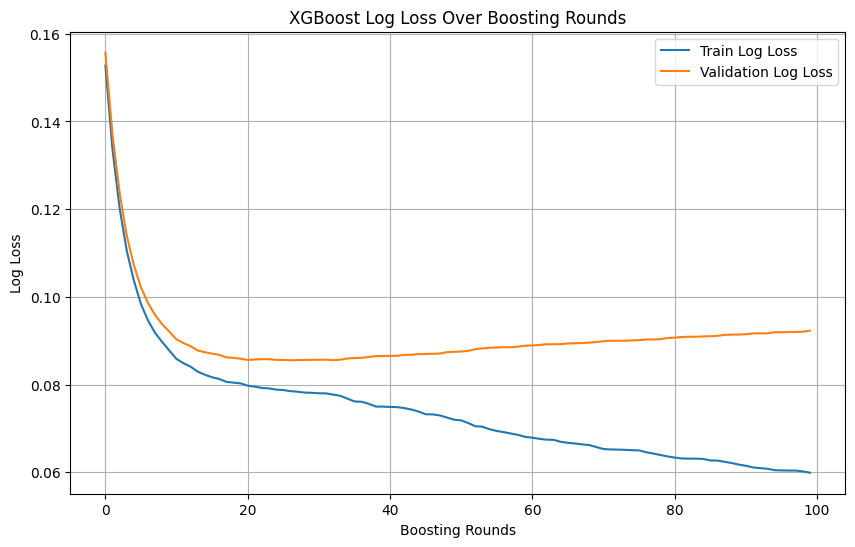

Results for train
train accuracy = 0.9766
train precision = 0.9911
train recall = 0.7423
train f1 = 0.8489
------------------------------------------
Results for validation
validation accuracy = 0.9671
validation precision = 0.9333
validation recall = 0.6769
validation f1 = 0.7847
------------------------------------------
Results for test
test accuracy = 0.9711
test precision = 0.9475
test recall = 0.7129
test f1 = 0.8136
------------------------------------------


In [103]:
exp_1(data= transformed_data, target="diabetes")

Observation When trained on default hyper-parameter, model is clearly overfitting to training set. This is clear from the separation between training and validation error

#### Test 2

Reduce number of estimators to 30 to aviod over-fitting

[0]	validation_0-logloss:0.15276	validation_1-logloss:0.15568
[29]	validation_0-logloss:0.07814	validation_1-logloss:0.08566


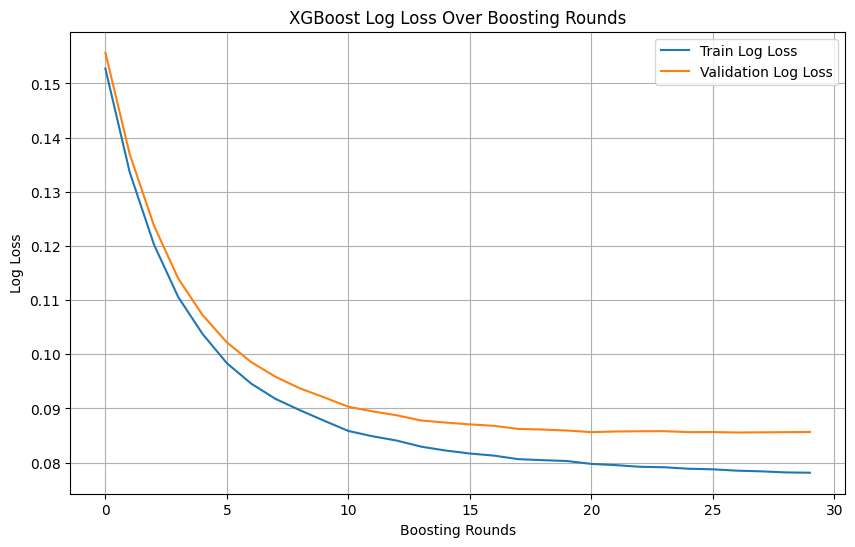

Results for train
train accuracy = 0.9715
train precision = 0.9840
train recall = 0.6889
train f1 = 0.8104
------------------------------------------
Results for validation
validation accuracy = 0.9688
validation precision = 0.9676
validation recall = 0.6698
validation f1 = 0.7916
------------------------------------------
Results for test
test accuracy = 0.9724
test precision = 0.9771
test recall = 0.7040
test f1 = 0.8184
------------------------------------------


In [104]:
exp_1(data= transformed_data, target="diabetes", param_dict={"n_estimators": 30})

Observation

poor recall as a result of imbalance in dataset

#### Test 3

Adjust class weight (scale_pos_weight hyper-paramer) to account for imbalance

[0]	validation_0-logloss:0.31611	validation_1-logloss:0.31759
[29]	validation_0-logloss:0.10504	validation_1-logloss:0.11338


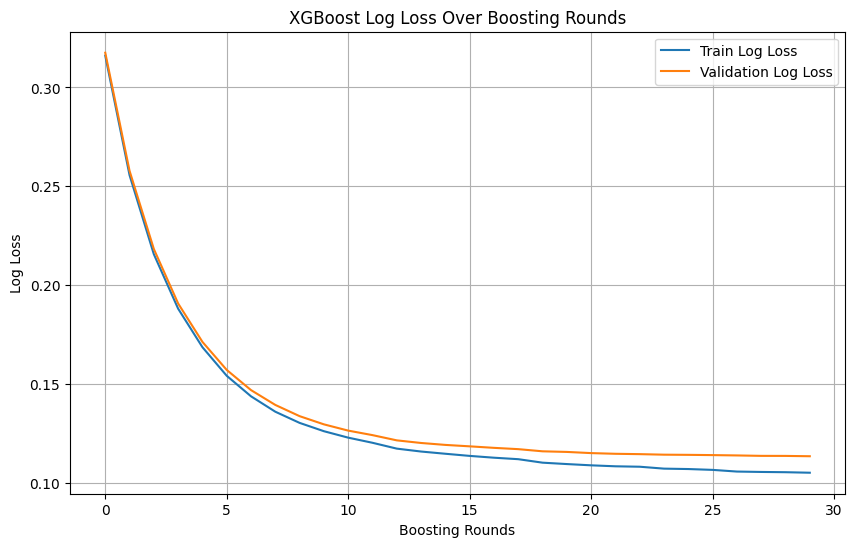

Results for train
train accuracy = 0.9578
train precision = 0.7321
train recall = 0.8241
train f1 = 0.7754
------------------------------------------
Results for validation
validation accuracy = 0.9539
validation precision = 0.7147
validation recall = 0.7978
validation f1 = 0.7540
------------------------------------------
Results for test
test accuracy = 0.9551
test precision = 0.7176
test recall = 0.8119
test f1 = 0.7618
------------------------------------------


In [106]:
exp_1(data= transformed_data, target="diabetes", param_dict={"n_estimators": 30, "scale_pos_weight": 4 })

#### Test 4

Adjust tree depth in attempt to imporve the general performance

[0]	validation_0-logloss:0.31611	validation_1-logloss:0.31759
[49]	validation_0-logloss:0.09838	validation_1-logloss:0.11301


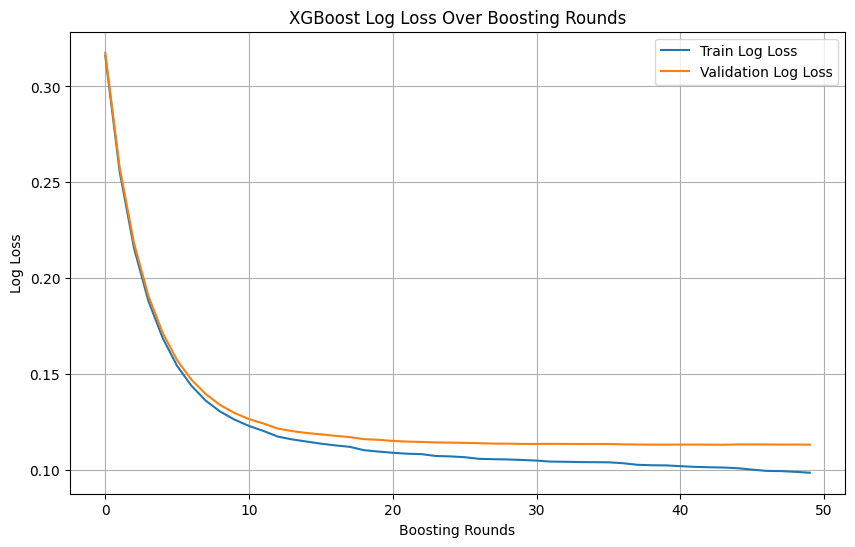

Results for train
train accuracy = 0.9588
train precision = 0.7313
train recall = 0.8438
train f1 = 0.7835
------------------------------------------
Results for validation
validation accuracy = 0.9518
validation precision = 0.6994
validation recall = 0.7972
validation f1 = 0.7451
------------------------------------------
Results for test
test accuracy = 0.9533
test precision = 0.7038
test recall = 0.8154
test f1 = 0.7555
------------------------------------------


In [107]:
exp_1(data= transformed_data, target="diabetes", param_dict={"n_estimators": 50, "scale_pos_weight": 4, "max_depth": 6})

#### Test 5 : Grid Search

In [109]:
# write a function to perform grid search
def perform_grid_search(data, target, param_grid):
    
    # split data to train, test and evaluation set
    X_data = data.drop([target], axis=1)
    y_data = data[target]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    

    # Initialize the XGBoost model
    xgb = XGBClassifier()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='recall', cv=3, verbose=2, n_jobs=-1)

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Return the best parameters
    return grid_search.best_params_

In [110]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    "scale_pos_weight": [4]
}

In [111]:
best_param = perform_grid_search(data= transformed_data, target="diabetes", param_grid=param_grid)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [113]:
best_param

{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'scale_pos_weight': 4,
 'subsample': 0.8}

[0]	validation_0-logloss:0.36752	validation_1-logloss:0.36877
[50]	validation_0-logloss:0.11159	validation_1-logloss:0.11577
[99]	validation_0-logloss:0.10673	validation_1-logloss:0.11354


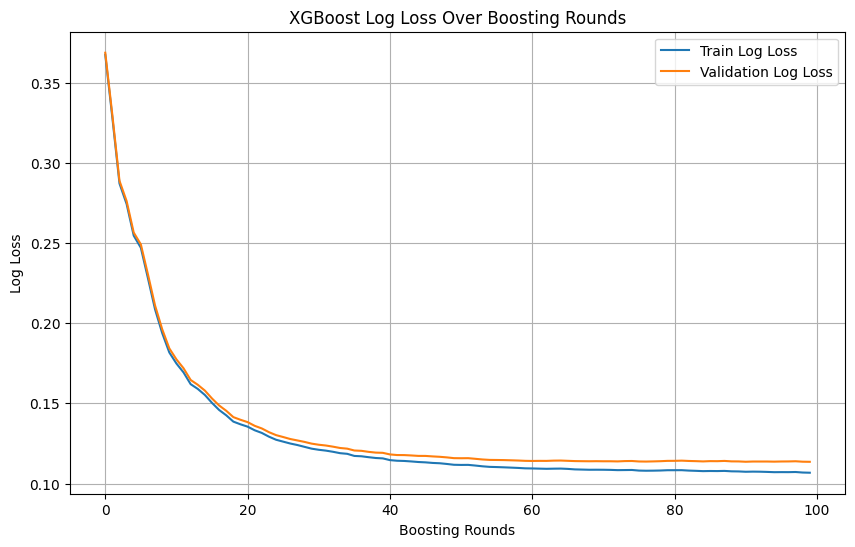

Results for train
train accuracy = 0.9560
train precision = 0.7181
train recall = 0.8284
train f1 = 0.7693
------------------------------------------
Results for validation
validation accuracy = 0.9517
validation precision = 0.6958
validation recall = 0.8066
validation f1 = 0.7471
------------------------------------------
Results for test
test accuracy = 0.9540
test precision = 0.7076
test recall = 0.8190
test f1 = 0.7592
------------------------------------------


In [114]:
exp_1(data= transformed_data, target="diabetes", param_dict=best_param)

Results shows good recall and precision without overfitting heavily

#### Train final model using the best hyper-parameters

In [115]:
best_param

{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'scale_pos_weight': 4,
 'subsample': 0.8}

In [116]:
def train_final_model(data, target, param_dict = {}):
    # Split data into X and y
    X_data = data.drop([target], axis=1)
    y_data = data[target]

    # Split data into train and final test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

    # Initialize classifier
    clf = XGBClassifier(**param_dict)

    # Train the model
    clf.fit(X_train_val, y_train_val)

    # Extract feature importance
    feature_importances = clf.feature_importances_

    # Create a DataFrame to hold feature importances
    importance_df = pd.DataFrame({
        'Feature': X_train_val.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()

    return importance_df, clf

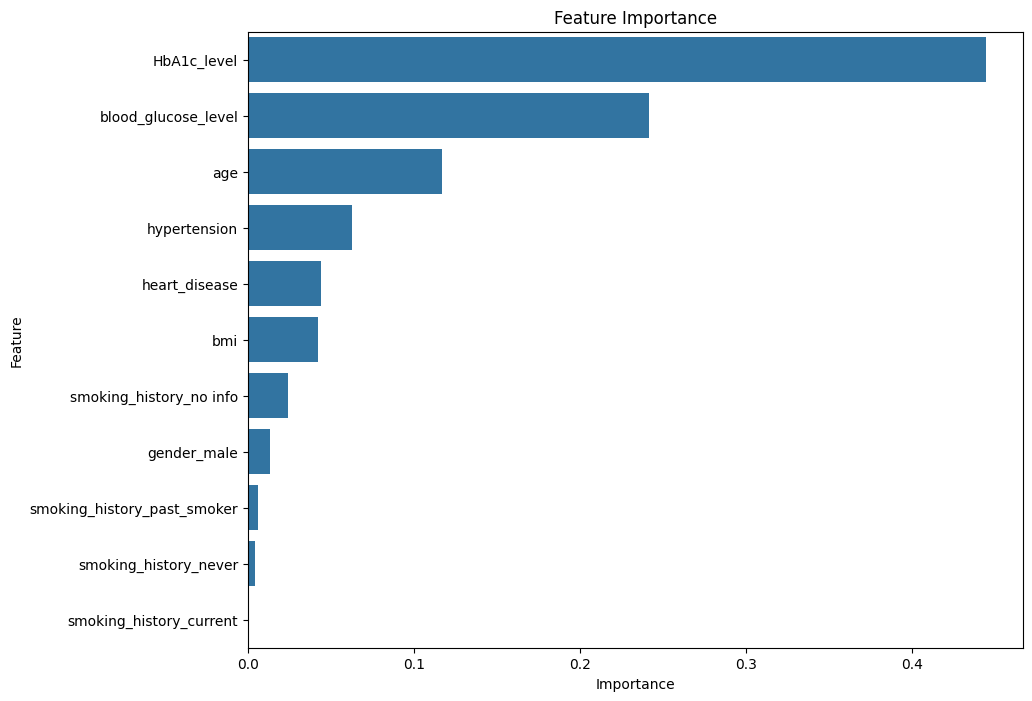

In [117]:
feature_importance, model = train_final_model(data= transformed_data, target="diabetes", param_dict=best_param)

In [118]:
feature_importance

,Feature,Importance
4,HbA1c_level,0.444601
5,blood_glucose_level,0.241671
0,age,0.117204
1,hypertension,0.062704
2,heart_disease,0.043883
3,bmi,0.042408
9,smoking_history_no info,0.024180
6,gender_male,0.013062
10,smoking_history_past_smoker,0.006117
8,smoking_history_never,0.004171


Top Features:

- HbA1c_level: This feature has the highest importance by a significant margin, indicating that it plays a critical role in the model's predictions.
- blood_glucose_level: This is the second most important feature, contributing significantly to the model's decisions.
- age: The third most important feature, suggesting that age has a meaningful impact on the prediction.
  
Moderately Important Features:

- hypertension: This feature also contributes significantly but less than the top three features.
- bmi: BMI is moderately important, implying it has some impact on the predictions but is not as crucial as the top features.
- heart_disease: This feature has a smaller, yet noticeable, contribution to the model’s prediction.
  
Less Important Features:

- smoking_history_no info and gender_male: These features have relatively low importance, meaning they have limited influence on the model’s prediction.
- smoking_history_past_smoker, smoking_history_current, and smoking_history_never: These features have very low importance, indicating that the model does not rely heavily on smoking history for its predictions.

KEY INSIGHTS

Data Integrity: The dataset was clean, with no missing values or major inconsistencies, ensuring smooth preprocessing and accurate model training.

Exploratory Findings:

Blood Glucose Level and HbA1c Level showed the strongest correlation with diabetes occurrence (0.42 and 0.40 respectively).

Age and BMI had moderate influence, while smoking history patterns revealed higher diabetes prevalence among former smokers and older individuals.

Feature Engineering:

Encoded categorical features like smoking history and scaled numerical variables to prepare for machine learning models.

Modeling & Evaluation:

Tested multiple algorithms — Logistic Regression, Decision Tree, Random Forest, and XGBoost.

XGBoost outperformed all, achieving the highest accuracy, recall, and F1-score, making it the most reliable model for predicting diabetes risk.

Key Predictors: Blood Glucose Level and HbA1c Level were the most influential features in determining diabetes likelihood.

##### Outcome: The XGBoost model successfully demonstrated how machine learning can be used to predict diabetes risk early, enabling data-driven healthcare interventions.
- 
RECOMENDATION
Focus on Key Predictors: Prioritize monitoring Blood Glucose Level and HbA1c Level during routine checkups, as they are the most significant indicators of diabetes risk.

Targeted Interventions for Smokers: Develop specific preventive programs for former and current smokers, especially those over 50 years old, as they show a higher prevalence of diabetes.

Enhanced Screening Protocols: Implement Random Forest-based predictive models in regular screenings to identify high-risk patients with greater accuracy and sensitivity.

Personalized Care Plans: Use the model’s predictions to design personalized care plans for at-risk individuals, focusing on lifestyle modifications, regular monitoring, and early interventions.

Data-driven Resource Allocation: Allocate healthcare resources more efficiently by focusing on high-risk groups, ensuring timely interventions and reducing long-term costs.

CONCLUSION
This project successfully developed a robust diabetes prediction model using advanced machine learning techniques. Through comprehensive data preprocessing, exploratory analysis, and rigorous model evaluation, key predictors such as Blood Glucose Level and HbA1c Level were identified as critical to diabetes risk. The insights derived provides actionable recommendations to enhance patient care, optimize resource allocation, and implement targeted preventive measures. By integrating this predictive model into its operations, doctors can take a proactive approach to combating diabetes, improving patient outcomes, and reducing long-term healthcare costs.